 
# <p style="text-align: center;">Heart Attack Prediction 🫀</p>

# Problem, Objective & Data Definition

## 🔎 Problem Statement
Heart disease is one of the leading causes of death worldwide. Early detection of heart disease is crucial to improve patient outcomes and reduce healthcare costs. The challenge lies in accurately predicting whether an individual is at risk of heart disease based on various medical and clinical parameters.
## 🎯 Objective
The objective of this task is to develop a predictive model that can determine whether a patient has a higher likelihood of experiencing a heart attack (target = 1) or a lower likelihood (target = 0) based on the provided medical attributes. The goal is to assist healthcare providers in making informed decisions about patient care and early intervention.



| **Attribute**                          | **Description**                                                                                     | **Values/Units**                                             |
|----------------------------------------|-----------------------------------------------------------------------------------------------------|-------------------------------------------------------------|
| **Age**                                | Patient's age                                                                                      | Years                                                       |
| **Sex**                                | Gender of the patient                                                                               | 1 = Male; 0 = Female                                        |
| **Cp**                    | Type of chest pain experienced                                                                      | 0 = Typical angina; 1 = Atypical angina; 2 = Non-anginal pain; 3 = Asymptomatic |
| **Trestbps**             | Resting blood pressure at admission                                                                | mm Hg                                                       |
| **Chol**                  | Serum cholesterol level                                                                            | mg/dl                                                      |
| **Fbs**                | Indicator of fasting blood sugar > 120 mg/dl                                                       | 1 = True; 0 = False                                         |
| **Restecg** | Results from ECG tests                                                                             | 0 = Normal; 1 = ST-T wave abnormality; 2 = Left ventricular hypertrophy |
| **Thalach**        | The maximum heart rate achieved during exercise                                                    | Beats per minute                                            |
| **Exang**            | Presence of angina caused by exercise                                                              | 1 = Yes; 0 = No                                             |
| **Oldpeak**                            | ST depression induced by exercise relative to rest                                                 | Numerical value                                             |
| **Slope** | Slope of the peak exercise ST segment                                                              | 0 = Upsloping; 1 = Flat; 2 = Downsloping                   |
| **Ca** | Number of major vessels visible in fluoroscopy                                                    | 0–3                                                        |
| **Thal**                 | Blood disorder condition                                                                           | 0 = Normal; 1 = Fixed defect; 2 = Reversible defect         |
| **Target**                             | Indicator of heart attack likelihood                                                               | 0 = Less likely; 1 = More likely                           |


## Import Libraries


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import optuna
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from joblib import dump, load



# Warnings Suppression
import warnings
warnings.filterwarnings('ignore')

# Notebook Settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
sns.set_palette("Spectral")
red = '#e84545'  # High Risk
green = '#93c47d'# Low Risk

# Reading Data

In [8]:
df = pd.read_csv("/kaggle/input/heart-attack-ds/heart.csv")

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# Exploratory Data Analysis

In [3]:
print ("Data size:", df.shape)

Data size: (303, 14)


In [4]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
sex,303.0,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0
cp,303.0,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0
trestbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0
thalach,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
exang,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


### Missing Values Percentage %


In [6]:
missing_percentage = (df.isna().mean() * 100).sort_values(ascending = False)
print(missing_percentage)

age         0.0
sex         0.0
cp          0.0
trestbps    0.0
chol        0.0
fbs         0.0
restecg     0.0
thalach     0.0
exang       0.0
oldpeak     0.0
slope       0.0
ca          0.0
thal        0.0
target      0.0
dtype: float64


### Checking Unique Values

In [7]:
for i in list(df.columns):
    print(f"{i} --> {df[i].nunique()}")

age --> 41
sex --> 2
cp --> 4
trestbps --> 49
chol --> 152
fbs --> 2
restecg --> 3
thalach --> 91
exang --> 2
oldpeak --> 40
slope --> 3
ca --> 5
thal --> 4
target --> 2


### Target Distribution

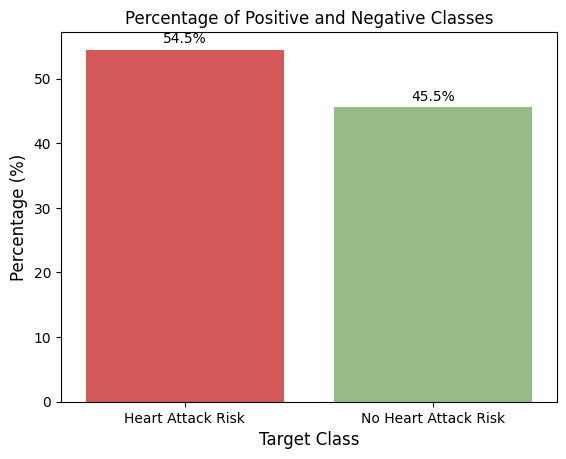

In [8]:
class_counts = df['target'].value_counts(normalize=True) * 100  
class_labels = {0: 'No Heart Attack Risk', 1: 'Heart Attack Risk'} 
class_counts.index = class_counts.index.map(class_labels)

# plt.figure(figsize=(6,3))
sns.barplot(x=class_counts.index, y=class_counts.values, palette={"Heart Attack Risk": red, "No Heart Attack Risk": green})
plt.title('Percentage of Positive and Negative Classes')
plt.ylabel('Percentage (%)', fontsize=12)
plt.xlabel('Target Class', fontsize=12)

for i, value in enumerate(class_counts.values):
    plt.text(i, value + 1, f'{value:.1f}%', ha='center')
plt.show()

- The distribution of the target variable shows that the dataset is almost balanced

## 1 - Categorical Feature Analysis


In [10]:
categorical_list = [col for col in df.columns if df[col].value_counts().shape[0] < 10 and col != 'target']

categorical_list

['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

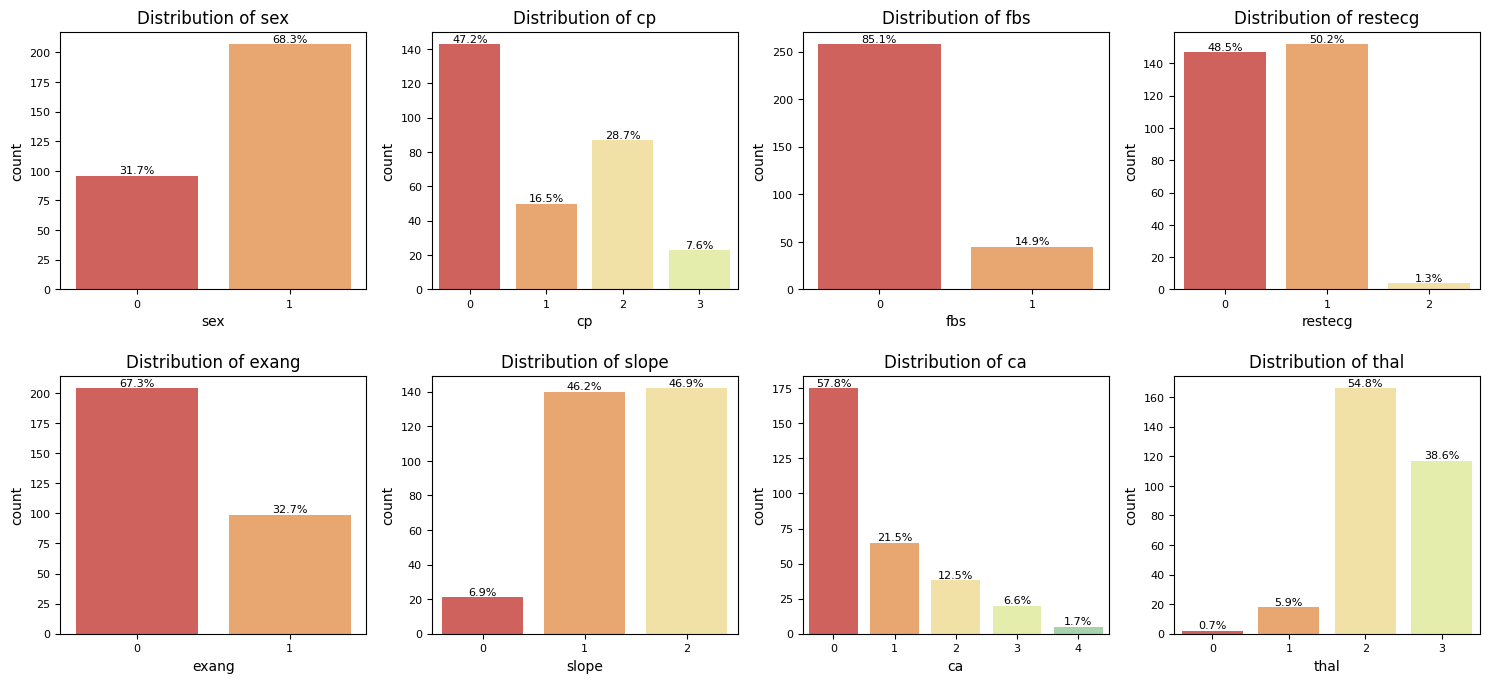

In [10]:
plt.figure(figsize=(15, 15))

for i, col in enumerate(categorical_list):
    plt.subplot(5, 4, i + 1)  
    ax = sns.countplot(
        data=df,
        x=col)
    
    total_counts = len(df)  
    for p in ax.patches:
        height = p.get_height()
        percentage = 100 * height / total_counts
        ax.annotate(f'{percentage:.1f}%', (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom', fontsize=8)

    plt.title(f'Distribution of {col}', fontsize=12)
    plt.yticks(fontsize=8)
    plt.xticks(fontsize=8)

plt.tight_layout()
plt.subplots_adjust(top=1.1)  
plt.show()

1. **Sex**
- Distribution:
    - Male (1): 68.32%
    - Female (0): 31.68%
- Insight:
    - Males constitute the majority of the dataset, with approximately two-thirds of the total population. 
2. **Chest Pain Type (cp)**
- Distribution:
    - Typical Angina (0): 47.19%
    - Non-Anginal Pain (2): 28.71%
    - Atypical Angina (1): 16.50%
    - Asymptomatic (3): 7.59%
- Insight:
    - Typical angina is the most common chest pain type, while asymptomatic cases are relatively rare.
3. **Fasting Blood Sugar(fbs)**
- Distribution:
    - FBS <= 120 mg/dL (0): 85.15%
    - FBS > 120 mg/dL (1): 14.85%
- Insight:
    - The majority of the population has normal fasting blood sugar levels. High fasting blood sugar levels are present in only 15% of the dataset

4. **Resting Electrocardiographic Results (restecg)**
- Distribution:
    - Normal (0): 48.51%
    - ST-T Wave Abnormality (1): 50.16%
    - Left Ventricular Hypertrophy (2): 1.32%
- Insight:
    - The dataset shows an almost even split between normal and ST-T wave abnormalities, while left ventricular hypertrophy is rare (1.32%). 
5. **Exercise-Induced Angina (exang)**
- Distribution:
    - No (0): 67.33%
    - Yes (1): 32.67%
- Insight:
    - Most individuals do not experience exercise-induced angina.
6. **Slope of the Peak Exercise ST Segment (slope)**
- Distribution:
    - Upsloping (2): 46.86%
    - Flat (1): 46.20%
    - Downsloping (0): 6.93%
- Insight:
    - Upsloping and flat slopes are almost equally prevalent, collectively accounting for 93% of cases. 
7. **Number of Major Vessels Colored by Fluoroscopy (ca)**
- Distribution:
    - 0 Vessels: 57.76%
    - 1 Vessel: 21.45%
    - 2 Vessels: 12.54%
    - 3 Vessels: 6.60%
    - 4 Vessels: 1.65%
- Insight:
    - Most patients (57.76%) have no major vessels colored. 
8. **Thalassemia Type (thal)**
- Distribution:
    - Reversible Defect (2): 54.79%
    - Fixed Defect (3): 38.61%
    - Normal (1): 5.94%
    - Undefined (0): 0.66%
- Insight:
    - Reversible and fixed defects dominate the dataset, with reversible defects being the most common. Normal thalassemia readings are rare, and undefined cases are negligible.


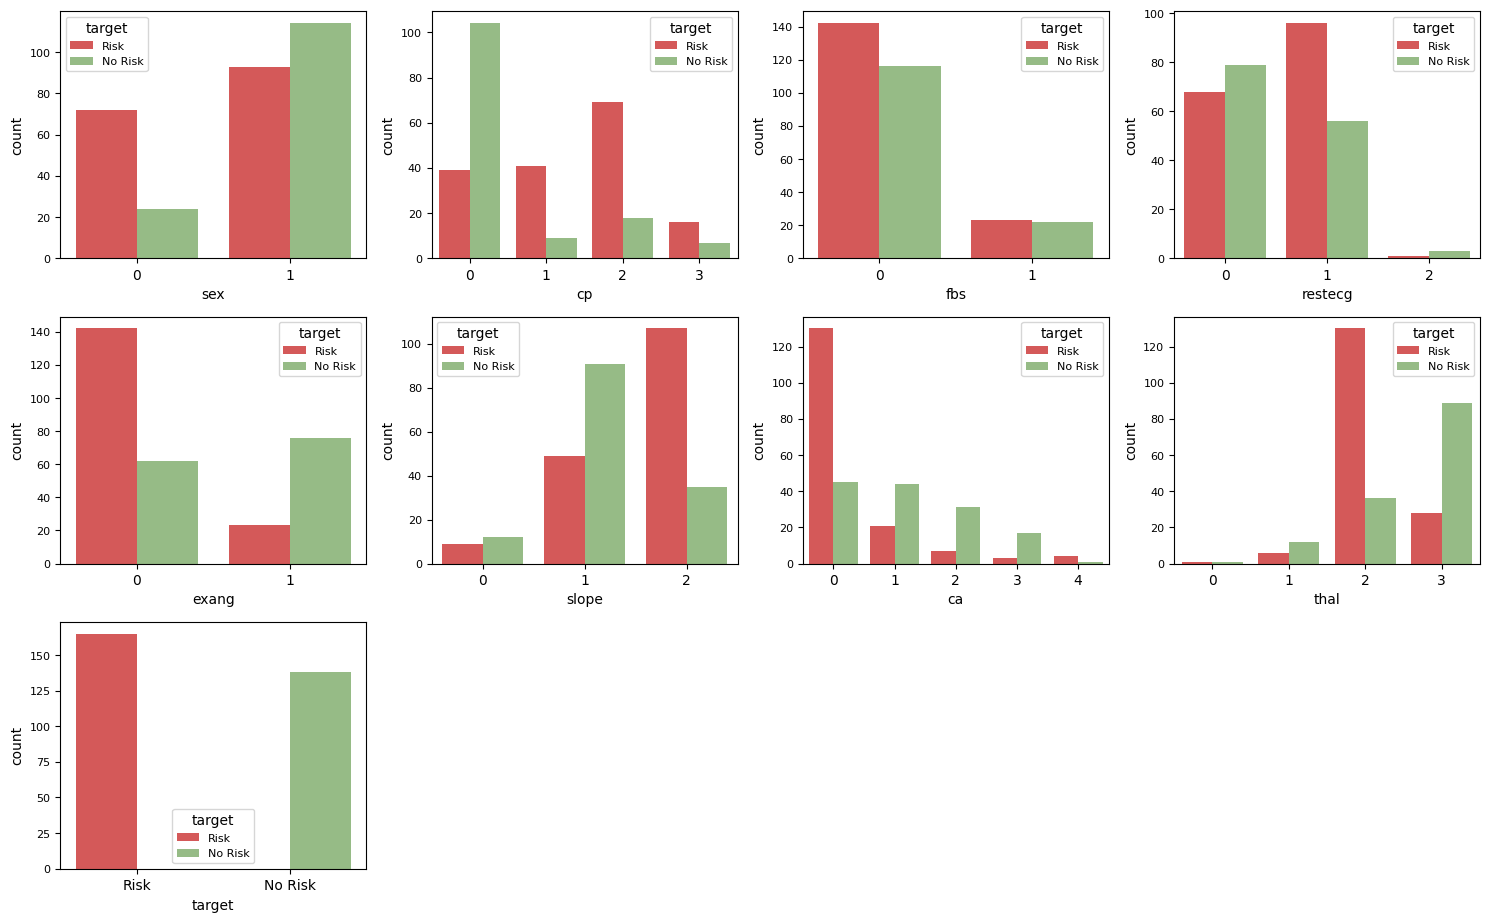

In [11]:
cat_df = df[categorical_list+['target']]
cat_df.loc[:,"target"] = cat_df["target"].replace({1:"Risk",0:"No Risk"})
plt.figure(figsize=(15,15))
for i, col in enumerate(cat_df):
    plt.subplot(5, 4, i + 1) 
    sns.countplot(data=cat_df, x=col, hue='target', palette={'Risk': red, 'No Risk': green})
    plt.legend(title='target', title_fontsize='10', fontsize='8')
    plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()

1. **Heart Attack Risk by Gender**
- Heart attacks are more common among females, this suggests that cardiovascular risk in women may be unrecognized, especially since symptoms may present differently than in men.

2. **Chest Pain Types and Heart Attack Risk**
- **Typical Angina (Cp = 0)** has a moderate risk of heart attack:
  - **Risk**: 12.9%
  - **No Risk**: 34.3%
  
- **Non-Anginal Pain (Cp = 2)** shows the highest risk:
  - **Risk**: 22.8% across all categories.
  - Non-anginal pain may indicate a more severe or acute form of heart disease.
  
- **Atypical Angina (Cp = 1)** and **Asymptomatic (Cp = 3)** are less likely to show high risk compared to typical or non-anginal pain.

3. **Fasting Blood Sugar (Fbs)**
- **Fbs = 0** (normal blood sugar levels) has a **46.9%** risk of heart disease, while **38.3%** show no risk.
  - Elevated fasting blood sugar is a known risk factor for heart disease, often linked to diabetes or pre-diabetes.
  
- **Fbs = 1** (high blood sugar) has a **7%** risk, suggesting the presence of high blood sugar could be a major risk factor.

4. **ECG Abnormalities and Heart Attack Risk**
- **ST-T Wave Abnormality (Restecg = 1)** has a significant **31.7%** increased risk of heart attack.
  - This suggests the presence of heart disease or possible ongoing cardiac events.

5. **Slope of the Peak Exercise ST Segment**
- **Downsloping (Slope = 2)** has the highest risk of **35.3%**.
  - A downsloping ST segment is a critical marker for coronary artery disease and indicates a higher likelihood of heart attacks under stress.

6. **Coronary Artery Defects**
- **Ca = 0** (no visible coronary vessels) shows the highest heart attack risk at **42%**.
  - The absence of visible coronary arteries on fluoroscopy may indicate severe coronary artery disease, suggesting a higher likelihood of adverse cardiac events.

7. **Thalassemia**
- **Reversible Defect in Thalassemia (Thal = 2)** has the highest heart attack risk at **42.9%**.
  - Thalassemia, particularly the reversible defect type, may affect blood oxygen levels and overall heart function, contributing to the increased risk of heart disease.

## 2. Numerical Feature Analysis

In [9]:
numerical_list = [col for col in df.columns if df[col].value_counts().shape[0] > 10 and col != 'target']

numerical_list

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

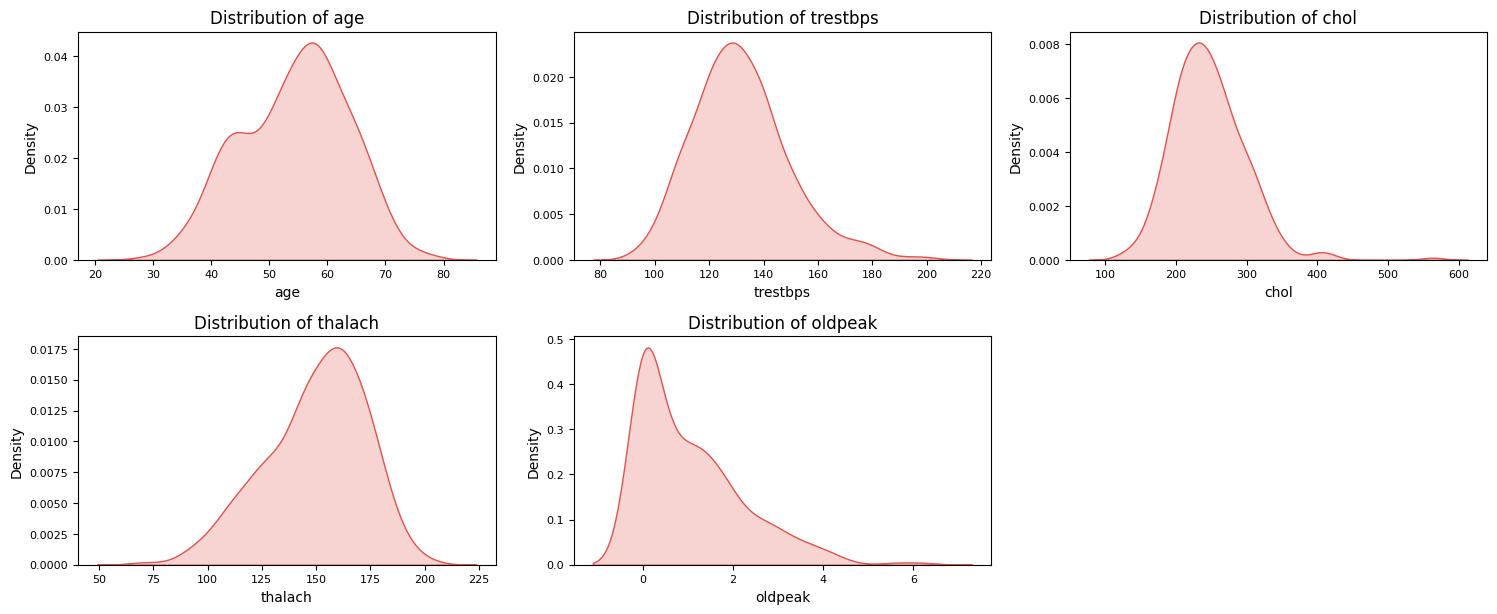

In [13]:
plt.figure(figsize=(15, 15))

for i, col in enumerate(numerical_list):
    plt.subplot(5, 3, i + 1)  
    ax = sns.kdeplot(df[col], fill=True)
    plt.title(f'Distribution of {col}', fontsize=12)
    plt.yticks(fontsize=8)
    plt.xticks(fontsize=8)

plt.tight_layout()
plt.show()

1. **Age**
   - Most individuals fall in the **50 to 60 age range**,as middle-aged individuals are a critical demographic for heart attack prediction.

2. **Maximum Heart Rate Achieved (Thalach)**
   - The maximum heart rate achieved during exercise peaks at **160 bpm**, with a standard deviation of **±20 bpm**.
   - Variations in this range could indicate abnormal cardiac function, which may increase heart attack risk.

3. **ST Depression Induced by Exercise Relative to Rest (Oldpeak)**
   - Most values for `oldpeak` are concentrated at **0**, ranging from **0 to 6**, with the distribution being **right-skewed**.
   - Higher `oldpeak` values are typically associated with **myocardial ischemia**, making this an important risk factor.

4. **Cholesterol Levels (Chol)**
   - Cholesterol levels are predominantly within the **200 to 300 mg/dL** range.
   - Elevated cholesterol is a key factor contributing to coronary artery disease and heart attacks.

5. **Resting Blood Pressure (Trestbps)**
   - Resting blood pressure ranges from **100 to 200 mmHg**, with peaks at **120, 130, and 140 mmHg**.
   - Elevated blood pressure (≥140 mmHg) is strongly linked to an increased likelihood of heart attacks.


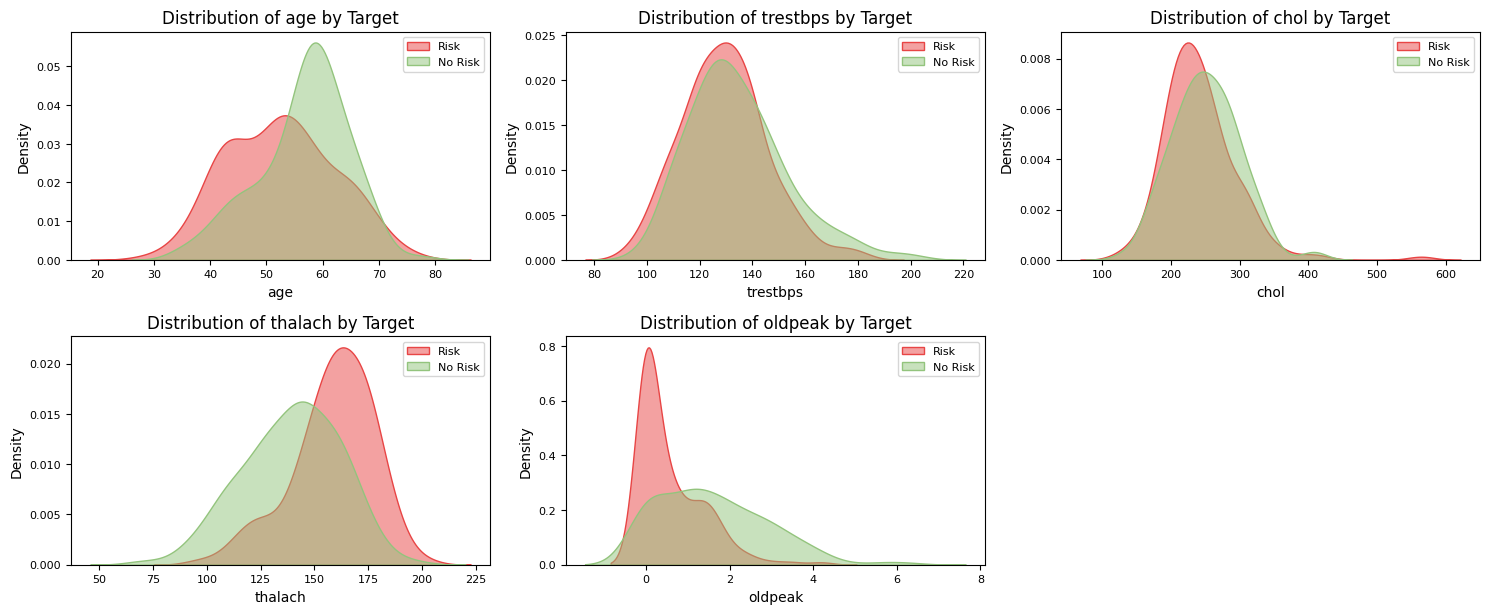

In [14]:
plt.figure(figsize=(15, 15))

for i, col in enumerate(numerical_list):
    plt.subplot(5, 3, i + 1)  
    sns.kdeplot(data=df[df['target'] == 1], 
                x=col, 
                fill=True, 
                color=red, 
                alpha=0.5, 
                label='Risk')
    sns.kdeplot(data=df[df['target'] == 0], 
                x=col, 
                fill=True, 
                color=green, 
                alpha=0.5, 
                label='No Risk')
    
    plt.title(f'Distribution of {col} by Target', fontsize=12)
    plt.yticks(fontsize=8)
    plt.xticks(fontsize=8)
    plt.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()


**Maximum Heart Rate Achieved (Thalach)**

- The distribution indicates that the maximum heart rate achieved during exercise is generally skewed toward higher values.
- all other distributions among the 2 classes are similar.

# Feature Engineering

### Age

In [15]:
df['age'].describe()

count    303.000000
mean      54.366337
std        9.082101
min       29.000000
25%       47.500000
50%       55.000000
75%       61.000000
max       77.000000
Name: age, dtype: float64

For simplicity and better model performance, we can group individuals who have similar levels of risk by binnig the age column.

In [16]:
age_bins = [0, 30, 45, 60, 75, 100] 
age_labels = ['0-30', '31-45', '46-60', '61-75', '76+'] 
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

print(df[['age', 'age_group']].head())

   age age_group
0   63     61-75
1   37     31-45
2   41     31-45
3   56     46-60
4   57     46-60


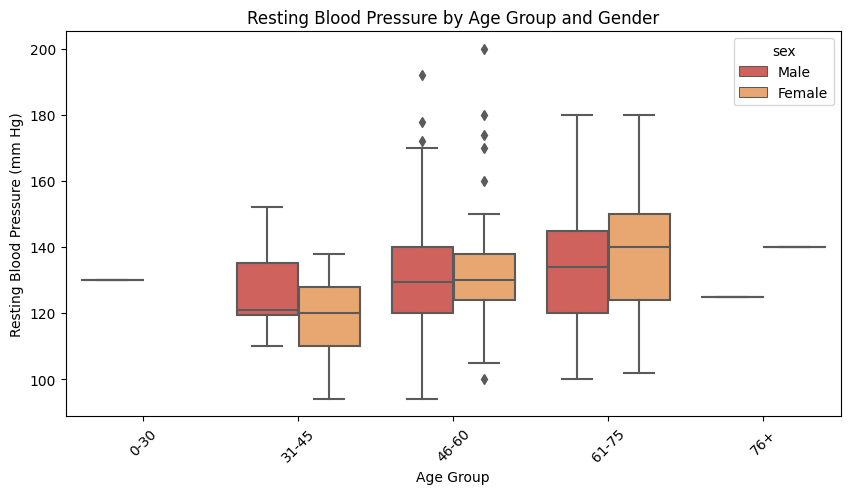

In [17]:
plt.figure(figsize=(10, 5))
dff = df.copy()
dff['sex']=df['sex'].replace({0:'Female',1:'Male'})
sns.boxplot(x='age_group', y='trestbps', hue='sex', data=dff)

plt.title('Resting Blood Pressure by Age Group and Gender')
plt.xlabel('Age Group')
plt.ylabel('Resting Blood Pressure (mm Hg)')
plt.xticks(rotation=45)
plt.show()


**Younger Adults (31-45 years)**:

- Women: Resting blood pressure ranges from 94 to 138 mm Hg, showing a wider range with some lower values compared to men.
- Men: Blood pressure ranges from 110 to 152 mm Hg, with a slightly higher maximum compared to women.

**Middle-aged Adults (46-60 years)**:

- Women: Blood pressure values vary significantly, ranging from 100 to 150 mm Hg, with outliers that reach 200 mm Hg.
- Men: Blood pressure ranges from 94 to 170 mm Hg, also showing variability but slightly higher than women in this age group.

**Older Adults (61-75 years)**:

- Women: Resting blood pressure ranges from 102 to 180 mm Hg.
- Men: Blood pressure ranges from 100 to 180 mm Hg, with slightly lower values for the majority compared to women in this age group.

### Thalach vs. Age

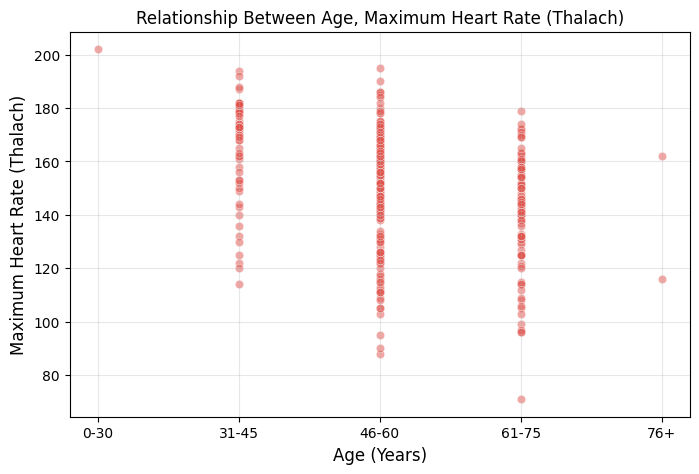

In [18]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='age_group', y='thalach', alpha=0.5)

plt.title('Relationship Between Age, Maximum Heart Rate (Thalach)')
plt.xlabel('Age (Years)', fontsize=12)
plt.ylabel('Maximum Heart Rate (Thalach)', fontsize=12)

plt.grid(True, alpha=0.3)
plt.show()

- Older individuals have lower maximum heart rates (thalach).

### Correlation matrix of continuous features


In [19]:
df_corr = df[numerical_list].corr().transpose()
df_corr

,age,trestbps,chol,thalach,oldpeak
age,1.000000,0.279351,0.213678,-0.398522,0.210013
trestbps,0.279351,1.000000,0.123174,-0.046698,0.193216
chol,0.213678,0.123174,1.000000,-0.009940,0.053952
thalach,-0.398522,-0.046698,-0.009940,1.000000,-0.344187
oldpeak,0.210013,0.193216,0.053952,-0.344187,1.000000


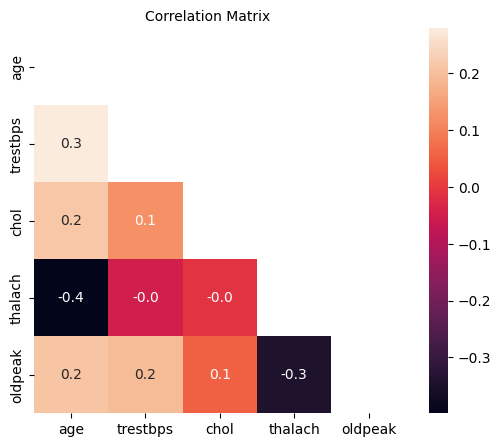

In [24]:
fig = plt.figure(figsize=(6,5))
gs = fig.add_gridspec(1,1)
gs.update(wspace=0.3, hspace=0.15)
ax0 = fig.add_subplot(gs[0,0])

mask = np.triu(np.ones_like(df_corr))
ax0.text(1.5,-0.1,"Correlation Matrix")
df_corr = df[numerical_list].corr().transpose()
sns.heatmap(df_corr,mask=mask,fmt=".1f",annot=True)
plt.show()

# Data Splitting

In [12]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y , stratify = y, test_size=0.2, random_state=42) 
# stratify = y to keep the same distribution among train and test

### Scaling Data

In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', RobustScaler(), numerical_list), 
        ('categorical', OneHotEncoder(drop = 'if_binary'), categorical_list),
    ])

- **Numeric Features**: 
  - For the numeric features we apply `RobustScaler`, which scales the features while being robust to outliers. It transforms each feature to have a median of 0 and a range defined by the interquartile range (IQR).

- **Categorical Features**:
  - For the categorical features we apply `OneHotEncoder`.

That's necessary for using LogisticRegression for modelling.


In [18]:
transformed_X = pd.DataFrame(preprocessor.fit_transform(X_train), columns = preprocessor.get_feature_names_out())

transformed_X_test = pd.DataFrame(preprocessor.transform(X_test), columns = preprocessor.get_feature_names_out())

In [28]:
transformed_X.head()

,numeric__age,numeric__trestbps,numeric__chol,numeric__thalach,numeric__oldpeak,categorical__sex_1,categorical__cp_0,categorical__cp_1,categorical__cp_2,categorical__cp_3,categorical__fbs_1,categorical__restecg_0,categorical__restecg_1,categorical__restecg_2,categorical__exang_1,categorical__slope_0,categorical__slope_1,categorical__slope_2,categorical__ca_0,categorical__ca_1,categorical__ca_2,categorical__ca_3,categorical__ca_4,categorical__thal_0,categorical__thal_1,categorical__thal_2,categorical__thal_3
0,0.964286,0.5,-0.016,-0.034783,0.555556,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.750000,1.5,0.096,-1.113043,-0.444444,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,-0.035714,-0.1,-0.560,-0.765217,0.666667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.107143,-1.0,1.520,-0.313043,1.222222,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.107143,-1.0,0.400,-0.765217,-0.444444,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Modeling

## 1. Logisitc Regression

In [19]:
# Base LogisticRegression model without regularization
base_lr = LogisticRegression(penalty = None,random_state=42)
base_lr.fit(transformed_X,
            y_train)

LogisticRegression(penalty=None, random_state=42)

**Evaluation Metrics**
- Since our data is almost balanced we can rely on accuracy as our metric.
- Also, AUC provides a summary of a model's performance across all possible classification thresholds. Unlike accuracy, which is sensitive to a specific threshold, AUC evaluates how well the model distinguishes between the positive and negative classes, independent of any threshold setting.


- In our case, minimizing False Negatives (FN) is more critical than minimizing False Positives (FP) (maximizing recall). This is because failing to identify a high-risk patient (FN) and not providing timely intervention for a potential heart attack could have severe consequences. On the other hand, a False Positive (e.g., predicting a heart attack when the person doesn't actually have one) is less harmful, even though it may result in unnecessary treatment or further tests. Prioritizing the reduction of FN ensures that high-risk patients are not missed.

**Adjusting the Threshold:**
- To minimize False Negatives, we want to make the model more sensitive to detecting the positive class (predicting a heart attack risk). This typically involves lowering the decision threshold so that the model predicts 1 (high risk) more often, even for cases where it is less certain.

In [20]:
# Get the probabilities for the positive class (class 1)

probabilities = base_lr.predict_proba(transformed_X_test)

# classify 1 if the probability for class 1 is >= 0.4, otherwise 0
predictions = (probabilities[:, 1] >= 0.4).astype(int)

print('Testing Report\n', classification_report(y_test, predictions))


Testing Report
               precision    recall  f1-score   support

           0       0.91      0.75      0.82        28
           1       0.82      0.94      0.87        33

    accuracy                           0.85        61
   macro avg       0.86      0.84      0.85        61
weighted avg       0.86      0.85      0.85        61



## Confusion Matrix

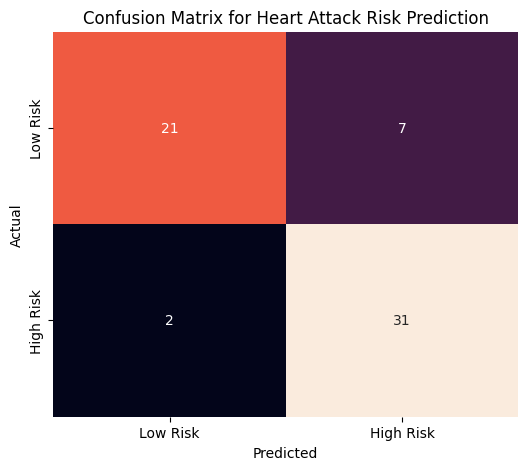

In [31]:
cm = confusion_matrix(y_test, predictions)
# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cbar=False, xticklabels=['Low Risk', 'High Risk'], yticklabels=['Low Risk', 'High Risk'])
plt.title('Confusion Matrix for Heart Attack Risk Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### AUC (Area Under the Curve)


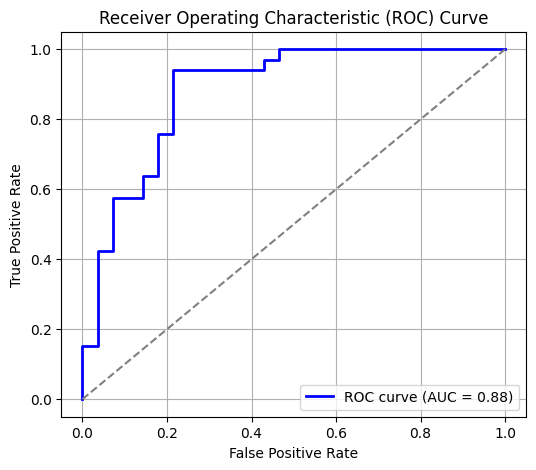

In [32]:
# Get the probabilities for the positive class (class 1)

probabilities = base_lr.predict_proba(transformed_X_test)[:,1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
# Diagonal line for random classifier
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


- The AUC of 0.88 means that the model has good discriminatory power and is able to distinguish between the positive class (heart attack risk) and the negative class (no heart attack risk) with an 88% probability of correctly ranking a randomly chosen positive instance higher than a randomly chosen negative instance.

## Hyperparameters Tuning


- Using Optuna

### Hyperparameters:

1. **`C` (Regularization Parameter)**:
   - **Purpose**: Controls the strength of regularization in Logistic Regression.
   - **Range**: A lower value increases regularization, and a higher value reduces regularization.

2. **`penalty` (Regularization Type)**:
   - **Purpose**: Specifies the type of regularization to apply. 
   - **Options**: 
     - `'l2'`: Ridge regularization, which penalizes large weights. It's the only option can be used with the `'lbfgs'`solver.
3. **`max_iter` (Maximum Number of Iterations)**:
   - **Purpose**: Defines the maximum number of iterations the solver should run.
4. **`tol` (Tolerance for Stopping Criteria)**:
   - **Purpose**: Defines the tolerance for stopping optimization. If the change in the loss function between iterations is smaller than this value, the solver will stop.
   - **Options**: A smaller value results in higher precision but may take longer to converge.

5. **`class_weight` (Weight for Classes)**:
   - **Purpose**: Addresses class imbalance by assigning a weight to each class, so that the model pays more attention to the minority class.
   - **Options**: 
     - `None`: No class weights are applied.
     - `'balanced'`: Automatically adjusts weights inversely proportional to class frequencies in the training data. This helps the model learn better when one class is underrepresented.

In [45]:
def objective(trial):
    
    # Define the remaining hyperparameters
    param_grid_lr = {
        'C': trial.suggest_float('C', 1, 1000),  # Regularization parameter
        'penalty': trial.suggest_categorical('penalty', ['l2']),  # Regularization type based on solver
        'max_iter': trial.suggest_int('max_iter', 50, 200),  # max_iter sampled from 50, 100, 150, 200
        'tol': trial.suggest_categorical('tol', [1e-6, 1e-5, 1e-4, 1e-3]),  # tolerance for stopping criteria
        'class_weight': trial.suggest_categorical('class_weight', ['balanced'])  # class_weight prevents bias toward the majority class

    }

    # Initialize and train the model
    estimator = LogisticRegression(**param_grid_lr)
    scores = cross_val_score(estimator, transformed_X, y_train, cv=5, scoring='accuracy', n_jobs=-1)

    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)


[I 2025-01-10 21:27:44,282] A new study created in memory with name: no-name-cc286c78-8cd6-4e85-9d16-b50c398fbd48
[I 2025-01-10 21:27:44,365] Trial 0 finished with value: 0.835204081632653 and parameters: {'C': 928.7835082562104, 'penalty': 'l2', 'max_iter': 155, 'tol': 0.0001, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.835204081632653.
[I 2025-01-10 21:27:44,446] Trial 1 finished with value: 0.835204081632653 and parameters: {'C': 541.6424895393995, 'penalty': 'l2', 'max_iter': 125, 'tol': 0.0001, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.835204081632653.
[I 2025-01-10 21:27:44,525] Trial 2 finished with value: 0.835204081632653 and parameters: {'C': 762.8440501918012, 'penalty': 'l2', 'max_iter': 125, 'tol': 1e-06, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.835204081632653.
[I 2025-01-10 21:27:44,606] Trial 3 finished with value: 0.8392857142857142 and parameters: {'C': 323.44836543423986, 'penalty': 'l2', 'max_iter': 182, 'tol': 1e-05

In [46]:
best_hyperparams = study.best_params
print("Best Hyperparameters:", best_hyperparams)

Best Hyperparameters: {'C': 1.9313539482268538, 'penalty': 'l2', 'max_iter': 97, 'tol': 0.0001, 'class_weight': 'balanced'}


In [47]:
tuned_lr = LogisticRegression(**best_hyperparams)
tuned_lr.fit(transformed_X,
            y_train)

LogisticRegression(C=1.9313539482268538, class_weight='balanced', max_iter=97)

In [48]:
# Get the probabilities for the positive class (class 1)

probabilities = tuned_lr.predict_proba(transformed_X_test)

# classify 1 if the probability for class 1 is >= 0.4, otherwise 0
predictions = (probabilities[:, 1] >= 0.4).astype(int)

print('Testing Report\n', classification_report(y_test, predictions))

Testing Report
               precision    recall  f1-score   support

           0       0.92      0.79      0.85        28
           1       0.84      0.94      0.89        33

    accuracy                           0.87        61
   macro avg       0.88      0.86      0.87        61
weighted avg       0.87      0.87      0.87        61



## Confusion Matrix

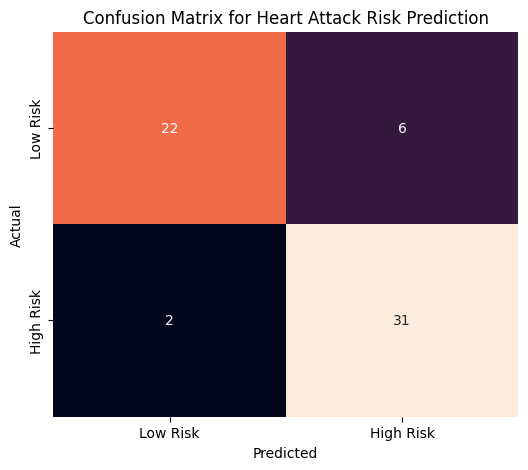

In [49]:
cm = confusion_matrix(y_test, predictions)
# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cbar=False, xticklabels=['Low Risk', 'High Risk'], yticklabels=['Low Risk', 'High Risk'])
plt.title('Confusion Matrix for Heart Attack Risk Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## AUC (Area Under Curve)

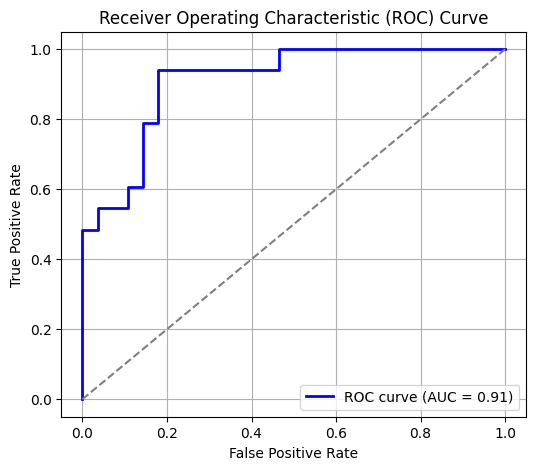

In [50]:
# Get the probabilities for the positive class (class 1)

probabilities = tuned_lr.predict_proba(transformed_X_test)[:,1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
# Diagonal line for random classifier
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### Comparison Between Non-Tuned and Tuned Models

| Metric           | Non-Tuned Model | Tuned Model |
|-------------------|-----------------|-------------|
| **Precision (Class 0)** | 0.91            | 0.92        |
| **Precision (Class 1)** | 0.82            | 0.84        |
| **Recall (Class 0)**    | 0.75            | 0.79        |
| **Recall (Class 1)**    | 0.94            | 0.94        |
| **F1-Score (Class 0)**  | 0.82            | 0.85        |
| **F1-Score (Class 1)**  | 0.87            | 0.89        |
| **Accuracy**            | 0.85            | 0.87        |

---

### What Changed?

1. **Accuracy Improved**  
   - The tuned model's overall accuracy increased from **85%** to **87%**.

2. **Better Balance for Class 0 (Low Risk)**  
   - The tuned model is slightly better at identifying low-risk cases (Class 0). Its recall and F1-score improved

3. **Consistent Performance for Class 1 (High Risk)**  
   - The tuned model maintained excellent recall for high-risk cases (Class 1) while slightly improving its precision and F1-score.
4. **AUC Improved**

   - The tuned model's AUC increased from **0.88** to **0.91**.

## 2. XGBoost

Xgboost doesn't require feature scaling, we will use target encoding for the categorical features, as it works better with xgboost.

In [13]:
# Transform categorical column to 'category' data type to apply target encoding
for col in categorical_list:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

encoder = TargetEncoder()

In [16]:
# Fit only the train data
encoded_X_train = encoder.fit_transform(X_train, y_train)
# Transform the test data
encoded_X_test = encoder.transform(X_test)

In [17]:
encoded_X = pd.DataFrame(encoded_X_train, columns=X_train.columns)
encoded_X_test = pd.DataFrame(encoded_X_test, columns=X_test.columns)

In [160]:
base_xgb = xgb.XGBClassifier(objective='binary:logistic',
        eval_metric='error') # num of wrong cases / all cases

base_xgb.fit(encoded_X,
             y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Model Performance

In [161]:
# Get the probabilities for the positive class (class 1)

probabilities = base_xgb.predict_proba(encoded_X_test)

# classify 1 if the probability for class 1 is >= 0.4, otherwise 0
predictions = (probabilities[:, 1] >= 0.4).astype(int)

print('Testing Report\n', classification_report(y_test, predictions))

Testing Report
               precision    recall  f1-score   support

           0       0.78      0.64      0.71        28
           1       0.74      0.85      0.79        33

    accuracy                           0.75        61
   macro avg       0.76      0.75      0.75        61
weighted avg       0.76      0.75      0.75        61



## AUC (Area Under Curve)

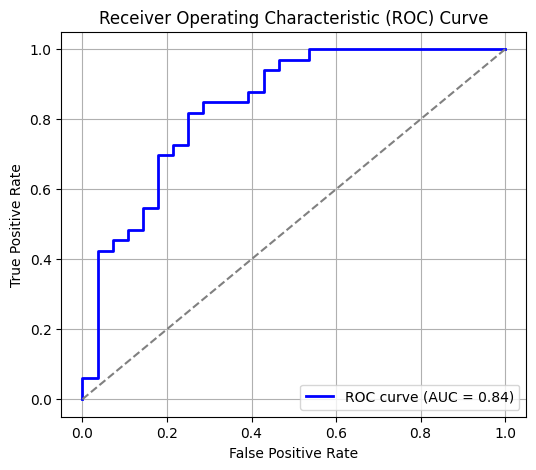

In [162]:
# Get the probabilities for the positive class (class 1)

probabilities = base_xgb.predict_proba(encoded_X_test)[:,1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
# Diagonal line for random classifier
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Confusion Matrix

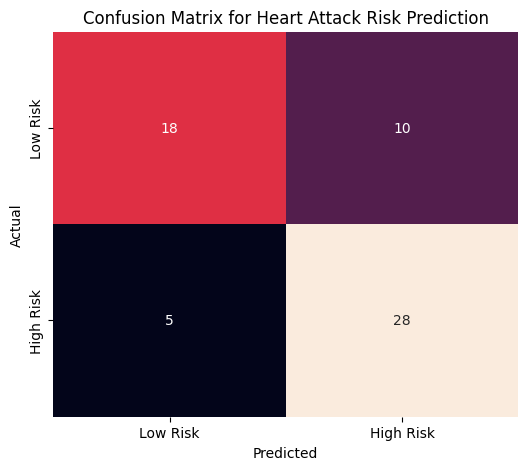

In [163]:
cm = confusion_matrix(y_test, predictions)
# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cbar=False, xticklabels=['Low Risk', 'High Risk'], yticklabels=['Low Risk', 'High Risk'])
plt.title('Confusion Matrix for Heart Attack Risk Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Hyperparameter Tuning

In [18]:
def objective(trial):
    
    param_grid = {
        'max_depth': trial.suggest_int('max_depth', 5, 35),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5),
        'gamma': trial.suggest_float('gamma', 0.1, 50.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10),
        'n_estimators': trial.suggest_int('n_estimators', 6, 40),
        'subsample': trial.suggest_float('subsample', 0.3, 0.5),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.5, 7),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.7,5)
    }

    estimator = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        **param_grid
    )
    scores = cross_val_score(estimator, encoded_X, y_train, cv=5, scoring='accuracy', n_jobs=-1)

    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

[I 2025-01-11 19:39:07,433] A new study created in memory with name: no-name-3c3f3064-d0f0-454b-8e60-0d0f7d07e129
[I 2025-01-11 19:39:09,864] Trial 0 finished with value: 0.8182823129251702 and parameters: {'max_depth': 6, 'learning_rate': 0.05737332033510786, 'gamma': 4.290428099645854, 'reg_lambda': 9.75720446991271, 'n_estimators': 38, 'subsample': 0.4092208040248933, 'min_child_weight': 3.7977330276004193, 'scale_pos_weight': 1.1363391219502155}. Best is trial 0 with value: 0.8182823129251702.
[I 2025-01-11 19:39:09,941] Trial 1 finished with value: 0.5454081632653061 and parameters: {'max_depth': 5, 'learning_rate': 0.052604072048553226, 'gamma': 22.464592338169076, 'reg_lambda': 6.185490909020473, 'n_estimators': 27, 'subsample': 0.3234745517415446, 'min_child_weight': 4.946664422760761, 'scale_pos_weight': 2.423578479651793}. Best is trial 0 with value: 0.8182823129251702.
[I 2025-01-11 19:39:10,003] Trial 2 finished with value: 0.8227891156462585 and parameters: {'max_depth': 3

In [21]:
best_hyperparams = study.best_params
print("Best Hyperparameters:", best_hyperparams)

Best Hyperparameters: {'max_depth': 19, 'learning_rate': 0.21993827565615393, 'gamma': 0.44207898631758996, 'reg_lambda': 2.9725125770538448, 'n_estimators': 40, 'subsample': 0.30734340106562563, 'min_child_weight': 3.142732799899963, 'scale_pos_weight': 0.985835091435126}


In [22]:
tuned_xgb =  xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',**best_hyperparams)
tuned_xgb.fit(encoded_X,
              y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.44207898631758996, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.21993827565615393,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=19, max_leaves=None,
              min_child_weight=3.142732799899963, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=40,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

### Finding the optimal threshold

Optimal Threshold: 0.5730892419815063


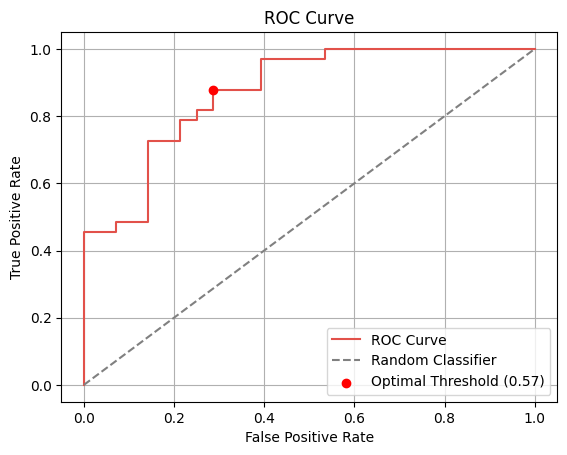

In [23]:
y_pred = tuned_xgb.predict_proba(encoded_X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Find the threshold that maximizes the distance to the diagonal
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f'Optimal Threshold: {optimal_threshold}')
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold ({optimal_threshold:.2f})', zorder=5)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()


## AUC (Area Under Curve)

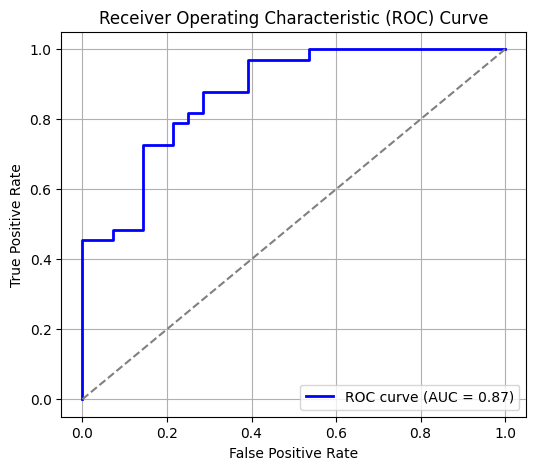

In [24]:
# Get the probabilities for the positive class (class 1)
probabilities = tuned_xgb.predict_proba(encoded_X_test)[:,1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
# Diagonal line for random classifier
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Model Perfomance

In [25]:
# Get the probabilities for the positive class (class 1)
probabilities = tuned_xgb.predict_proba(encoded_X_test)

# classify 1 if the probability for class 1 is >= 0.4, otherwise 0
predictions = (probabilities[:, 1] >=  optimal_threshold).astype(int)

print('Testing Report\n', classification_report(y_test, predictions))

Testing Report
               precision    recall  f1-score   support

           0       0.83      0.71      0.77        28
           1       0.78      0.88      0.83        33

    accuracy                           0.80        61
   macro avg       0.81      0.80      0.80        61
weighted avg       0.81      0.80      0.80        61



## Feature Importance

<Figure size 1400x1000 with 0 Axes>

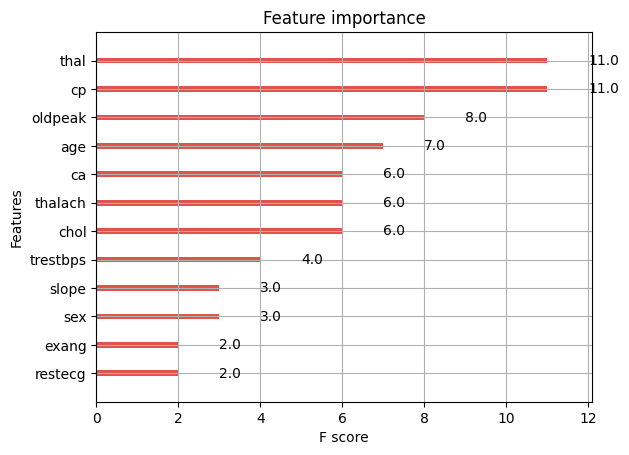

In [26]:
plt.figure(figsize = (14,10))
xgb.plot_importance(tuned_xgb, importance_type='weight')
plt.show()

**Based on the feature importance analysis**

1. **Cp (Type of Chest Pain)**: 
   - This suggests that the type of chest pain plays a key role in determining the likelihood of the target outcome.

2. **Oldpeak (ST Depression Induced by Exercise)**:
   - the changes in ST depression during exercise are an important indicator for making predictions.

3. **Ca (Number of Major Vessels Visible in Fluoroscopy)**:
   - it highliths the importance of vascular health in predicting the target outcome.

4. **Thal (Blood Disorder Condition)**:
   - This feature highlights the presence of blood disorders as an important factor influencing the prediction.

5. **Chol (Serum Cholesterol Level)**:
   - The cholesterol levels are an important predictor for the target variable.


In this case Logistic Regression outperformed the XGboost model.
    
**Key Observations:**
- Accuracy: 
    -Logistic Regression achieved a higher overall accuracy (0.87) compared to XGBoost (0.82).

- Precision vs. Recall:

    - Logistic Regression had higher precision for both Class 0 (0.92) and Class 1 (0.84).
    - XGBoost, although it had higher precision for Class 0 (0.95), struggled with lower recall for Class 0 (0.64), while achieving better recall for Class 1 (0.97).
                                                                                        
- F1-Score:

    - Logistic Regression had higher F1-scores for both classes, particularly for Class 1 (0.89 vs. 0.85), suggesting better balance between precision and recall.

Why Logistic Regression might outperformed XGBoost?
        
- The dataset is relatively small, and Logistic Regression, being a simpler model, is less prone to overfitting compared to XGBoost, which has a higher capacity for overfitting when there's limited data.
Overfitting in XGBoost: XGBoost, while more powerful and flexible, might have overfit to the noise in the small dataset. The low recall for Class 0 suggests that XGBoost might have failed to generalize well on this class, focusing more on Class 1.
XGBoost is a more complex model, requiring fine-tuning to avoid overfitting and to work well with small datasets. On the other hand, Logistic Regression is computationally simpler and more efficient for small datasets, leading to better performance in this scenario.
Logistic Regression provided a more balanced performance, maintaining higher precision, recall, and F1-scores across both classes.


In [28]:
# Save the xgboost model to a file
dump(tuned_xgb, 'XGB_model.joblib')
dump(encoder, 'xgb_preprocessor.joblib')


['xgb_preprocessor.joblib']

In [23]:
# Save the LR model to a file
dump(tuned_lr, 'Heart_attack_Model.joblib')
dump(preprocessor, 'column_transformer.joblib')


['column_transformer.joblib']